In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

import torch_nf
from torch_nf.conditional_nf import NormFlow, ConditionedNormFlow
from torch_nf.error_formatters import dbg_check
from torch_nf.systems import MF_V1_4n
from torch_nf.util import plot_dist
from torch_nf.lfi import train_SNPE, train_APT
from torch_nf.bijectors import ToInterval
from torch_nf.lfi import SNPE_proposal

import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
system = MF_V1_4n()

N = 1000
W = np.random.uniform(0., 2., (N, 4, 4))
W[:,1:] = -W[:,1:]
#sigma = np.random.uniform(0., 2., (N, 4, 4))
b = np.random.uniform(1., 0.1, (N, 4))

z = np.concatenate((np.reshape(W, (N, 4*4)), b), axis=1)
x = system.simulate(z)
x0 = np.array([[0.14446039, 0.2412575,  0.36162094, 
                0.23536153, 0.19078061, 0.18227517,
                0.43703067, 0.47571289, 0.65682352,
                0.1487949,  0.20043895, 0.24761808,
                0.32097366, 0.20411271, 0.17350747,
                0.31401437, 0.2942019,  0.38232728,]])
x0[9:] = x0[9:]**2


In [3]:


# Opt params
D = system.D
M = 2000
M_atom = 100
num_iters = 100
R = 2

# two-network arch
arch_type = 'autoregressive'
hidden_layers = [64, 64]

rs = 1
np.random.seed(rs)
torch.manual_seed(rs)

#lb = -float('inf')*np.ones((D,)) #system.lb
#ub = float('inf')*np.ones((D,)) #system.ub
lb = system.lb
ub = system.ub
support_layer = ToInterval(D, lb, ub)

nf = NormFlow(D, arch_type, True, num_stages=1, 
              num_layers=2, num_units=25, support_layer=support_layer)
cnf = ConditionedNormFlow(nf, x0.shape[1], hidden_layers, dropout=False)
print(cnf.param_net)

Sequential(
  (linear1): Linear(in_features=18, out_features=64, bias=True)
  (tanh1): Tanh()
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): Tanh()
  (linear3): Linear(in_features=64, out_features=3290, bias=True)
)


In [ ]:
M = 1000
x0_torch = torch.tensor(x0).float()
z, q_z, x = SNPE_proposal(1, M, system, cnf, x0_torch)

M 4
M 13
M 18
M 24
M 30
M 34
M 37
M 40


### Run SNPE

<Figure size 432x288 with 0 Axes>

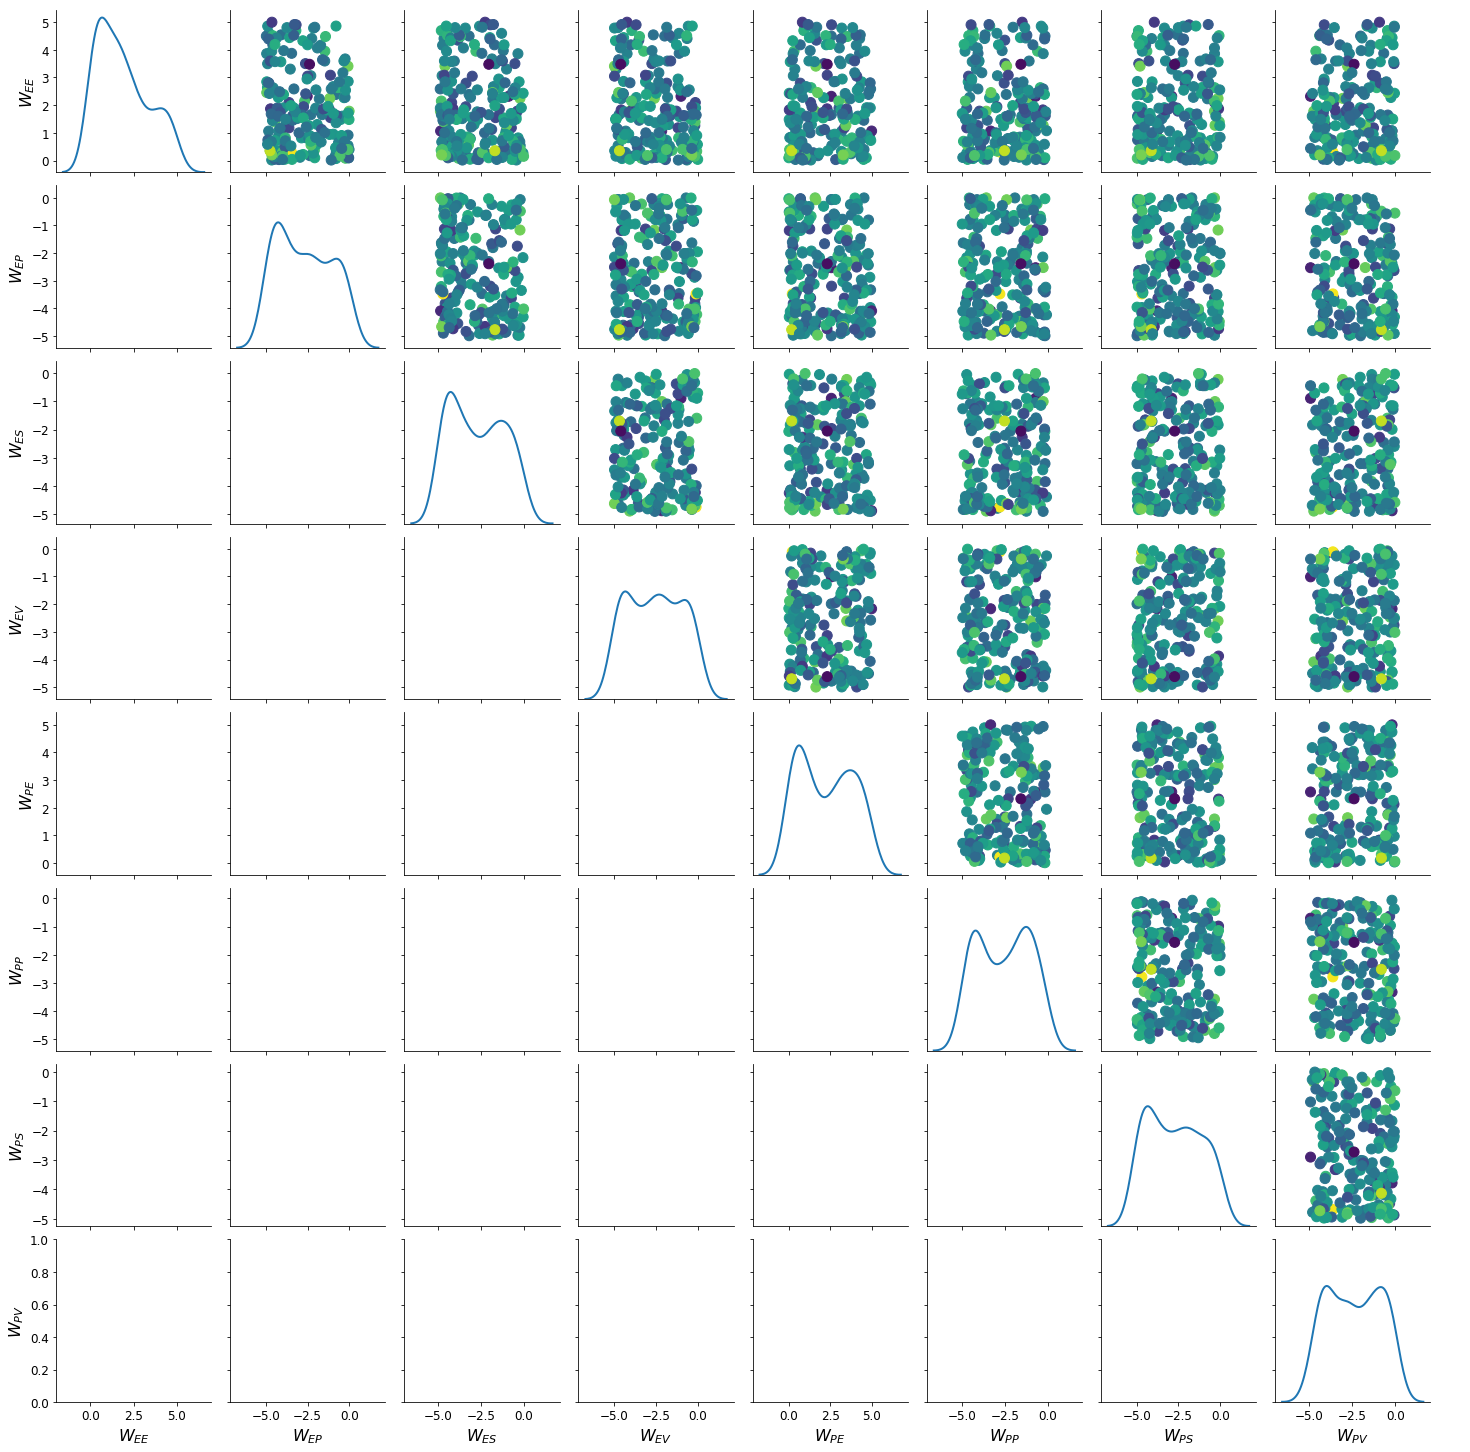

r 1, it 1, loss=6.37E+00, time/it=0.100
r 1, it 5, loss=6.23E+00, time/it=0.099
r 1, it 10, loss=6.36E+00, time/it=0.094
r 1, it 15, loss=5.55E+00, time/it=0.092
r 1, it 20, loss=5.22E+00, time/it=0.097
r 1, it 25, loss=5.25E+00, time/it=0.095
r 1, it 30, loss=5.44E+00, time/it=0.097
r 1, it 35, loss=5.19E+00, time/it=0.096
r 1, it 40, loss=5.12E+00, time/it=0.095
r 1, it 45, loss=5.36E+00, time/it=0.097
r 1, it 50, loss=5.07E+00, time/it=0.097
r 1, it 55, loss=5.08E+00, time/it=0.094
r 1, it 60, loss=5.64E+00, time/it=0.095
r 1, it 65, loss=5.25E+00, time/it=0.097
r 1, it 70, loss=5.02E+00, time/it=0.097
r 1, it 75, loss=5.16E+00, time/it=0.101
r 1, it 80, loss=4.91E+00, time/it=0.098
r 1, it 85, loss=4.97E+00, time/it=0.096
r 1, it 90, loss=5.17E+00, time/it=0.096
r 1, it 95, loss=4.79E+00, time/it=0.096
r 1, it 100, loss=5.04E+00, time/it=0.096


<Figure size 432x288 with 0 Axes>

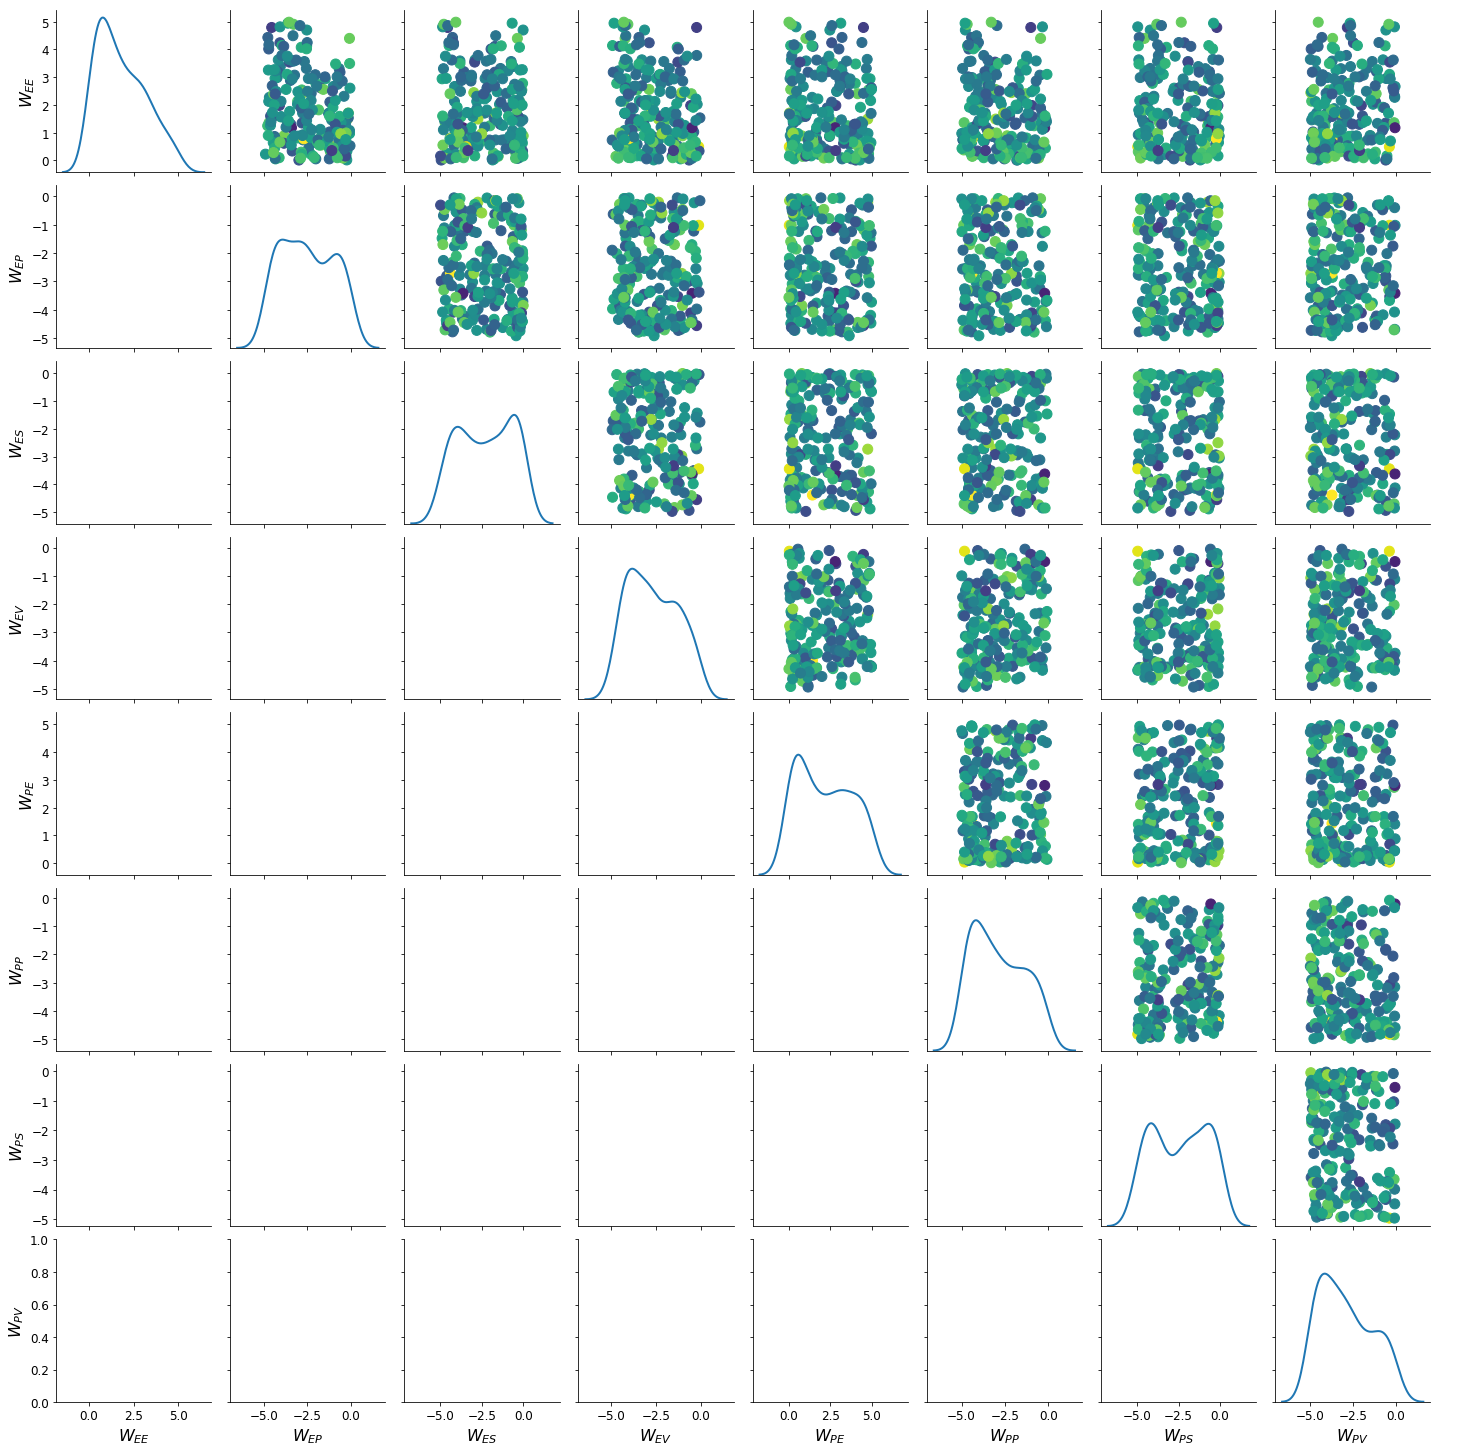

KeyboardInterrupt: 

In [7]:
cnf, losses, zs, log_probs, it_time = train_APT(
    cnf, 
    system, 
    x0, 
    M=M, 
    M_atom=M_atom, 
    R=R, 
    num_iters=num_iters,
    verbose=True
)

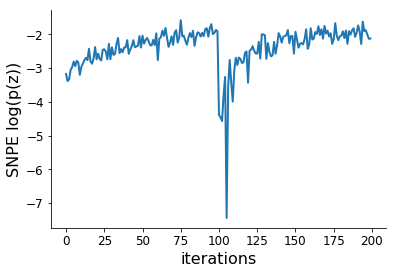

In [7]:
_losses = np.array(losses)
plt.figure()
plt.plot(-_losses)
plt.xlabel('iterations')
plt.ylabel('SNPE log(p(z))')
plt.show()

In [8]:
x0_torch = torch.tensor(x0).float()
z, log_prob= cnf(x0_torch, N=100)

<Figure size 432x288 with 0 Axes>

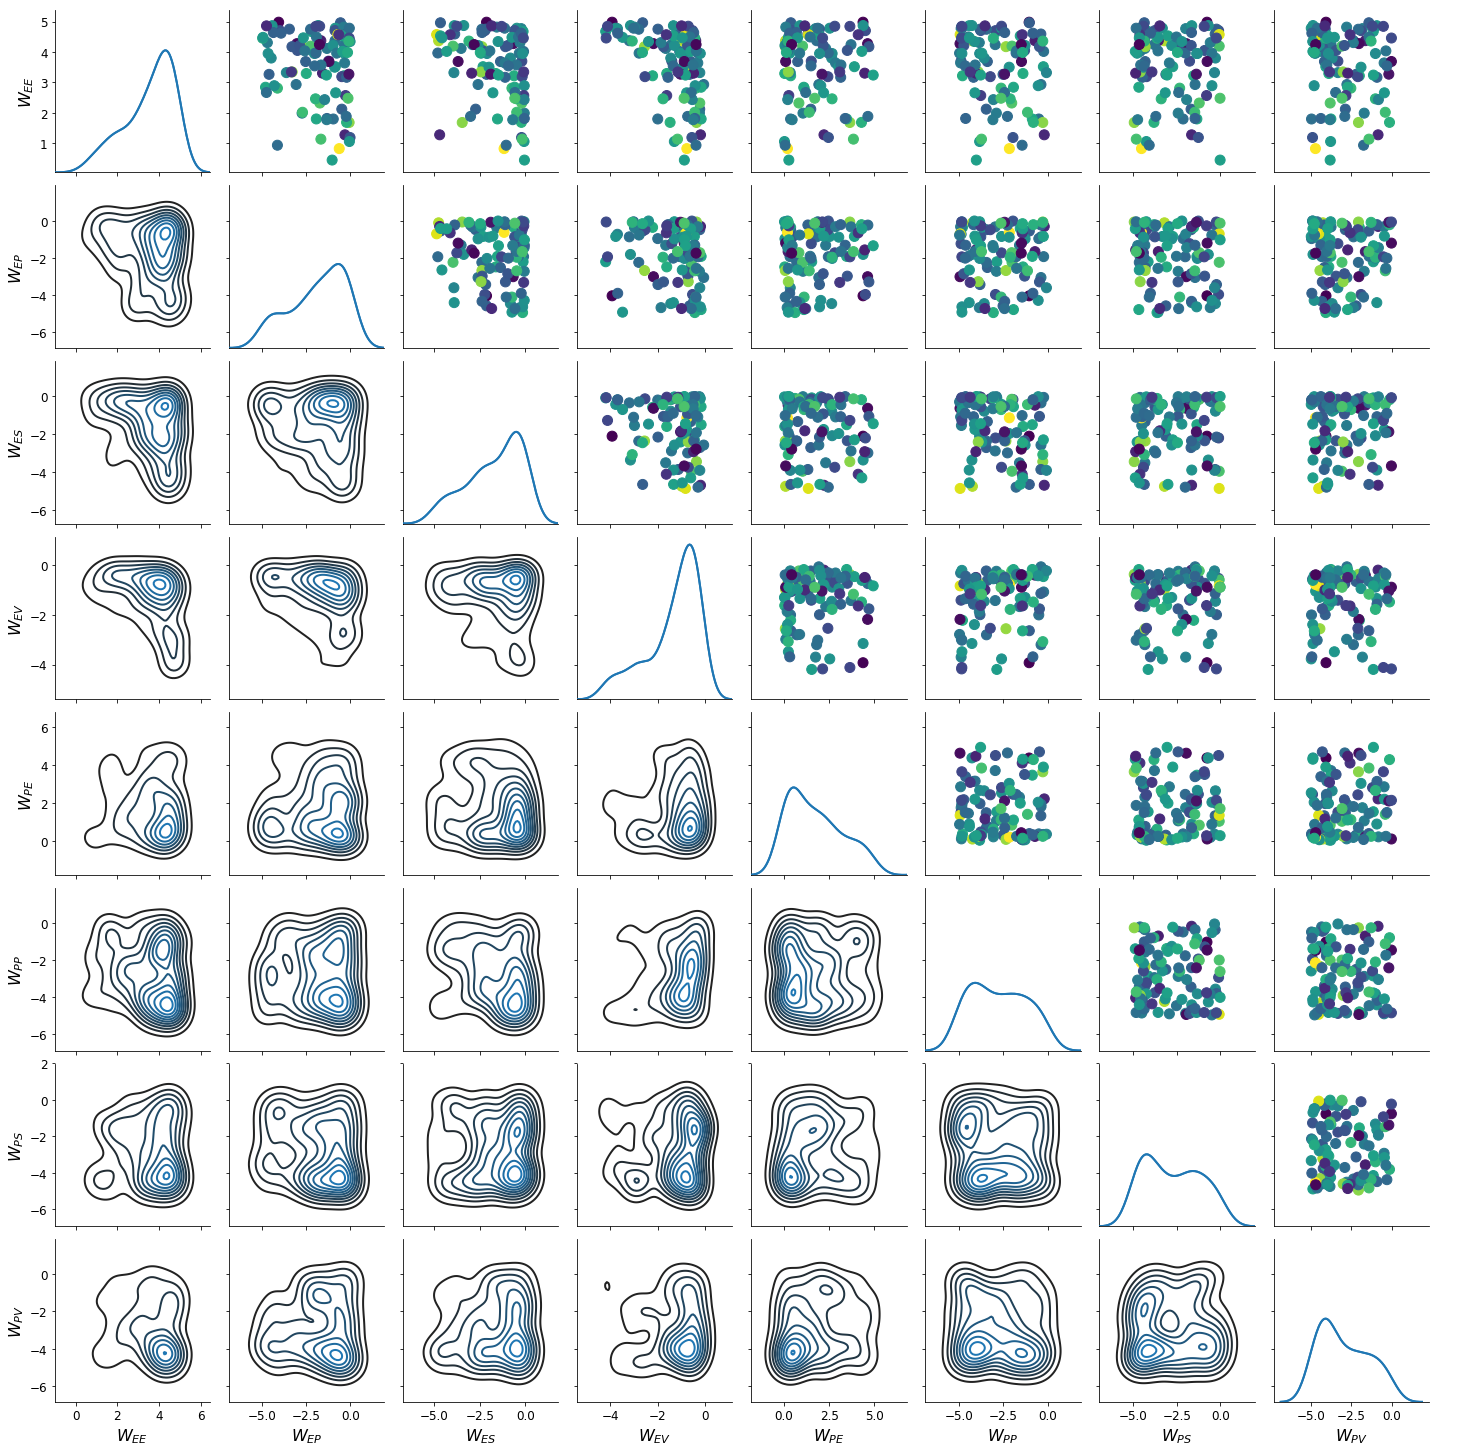

In [9]:
plt.figure()
g = plot_dist(
    z.detach().numpy()[0], 
    log_prob.detach().numpy()[0], 
    kde=True, 
    z_labels=system.z_labels,
    inds=[i for i in range(8)],
)
